<a href="https://colab.research.google.com/github/arthurpeter/Machine_Learning/blob/main/%5BSkel%5D_Lab_Lung_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.5 MB/s eta 0:00:00


# !python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!pip install einops
!python -c "import monai" || pip install 'monai[all]'

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [3]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0

print('You are using gpu if true, cpu if false:', cuda)

You are using gpu if true, cpu if false: True


## Test data

În MONAI, există clase dedicate pentru gestionarea seturilor de date medicale standardizate, precum DecathlonDataset.

Aceste clase facilitează preprocesarea și accesul la date pentru diverse sarcini de învățare automată în imagistica medicală. Mai jos este un exemplu de cod în care utilizăm clasa DecathlonDataset pentru a descărca și încărca datele aferente sarcinii de segmentare a cancerului de plămâni (Task06_Lung).

Acest cod descarcă automat datele Task06_Lung (dedicate segmentării plămânilor) în directorul specificat și permite accesul direct la ele prin obiectul dataset. Astfel, putem accesa rapid numărul total de sample-uri și datele unui subiect individual.

In [4]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = None, download = True)
print(f"\nnumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [02:52, 53.2MB/s]                            

2025-11-12 08:23:56,768 - INFO - Downloaded: Task06_Lung.tar


2025-11-12 08:24:34,776 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2025-11-12 08:24:34,777 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 311821.43it/s]


number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


În MONAI, încărcarea imaginilor poate fi realizată folosind o abordare de tip "lazy loading," care permite încărcarea efectivă a datelor doar atunci când sunt necesare. Acest lucru este esențial în lucrul cu date medicale de mari dimensiuni, deoarece economisește memorie și timp, mai ales în scenarii de antrenare și validare, unde nu este necesar să avem toate datele încărcate simultan în memorie.

În exemplul de mai jos, folosim LoadImageD pentru a încărca o imagine și eticheta sa asociată specificate prin calea fișierului. Aceasta ne permite să verificăm forma imaginii și a etichetei, asigurându-ne că datele sunt compatibile cu modelul de segmentare.

In [5]:
# Load random to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz",
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"image shape: {data_check['image'].shape} \nlabel shape: {data_check['label'].shape}")

image shape: torch.Size([512, 512, 589]) 
label shape: torch.Size([512, 512, 589])


Vizualizarea imaginilor și a etichetelor de segmentare este un pas important în pregătirea datelor pentru a ne asigura că acestea sunt corect aliniate și că structurile de interes sunt bine definite. În codul de mai jos, alegem un slice specific dintr-o imagine 3D și îl afișăm alături de eticheta sa de segmentare. Folosim imshow din matplotlib pentru a vizualiza secțiunea din imagine în tonuri de gri și pentru a suprapune eticheta în culori, folosind transparența (cu alpha = 0.5). Această suprapunere permite o comparație vizuală între structura segmentată și masca etichetată.

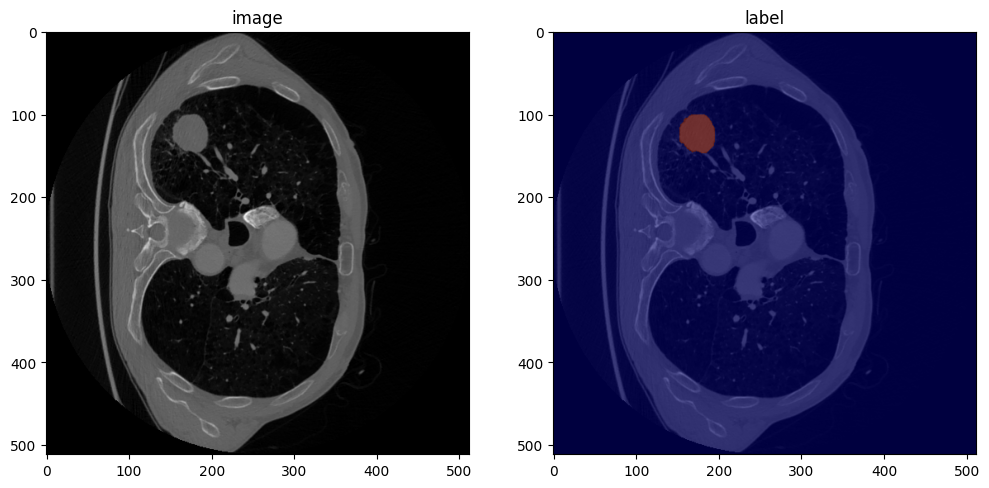

In [6]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

### Exercițiul 1

Implementați o variantă prin care să afișați o secvență de 10 slice-uri (secțiuni) la intervale egale dintr-un CT, începând de la o poziție de start prestabilită. Fiecare slice trebuie să fie afișat într-un subplot separat, iar etichetele axelor să fie ascunse pentru claritate.

Pentru fiecare slice, veți afișa suprapunerea dintre imagine și masca de segmentare (ca în exemplul anterior).

Schimbați valorile pentru poziția de start, distanța dintre slice-urile alese și rulați.

Puteți porni de la ```data_check```.

Hint: ```fig, axes = plt.subplots(1, num_slices, figsize=(20, 6))```

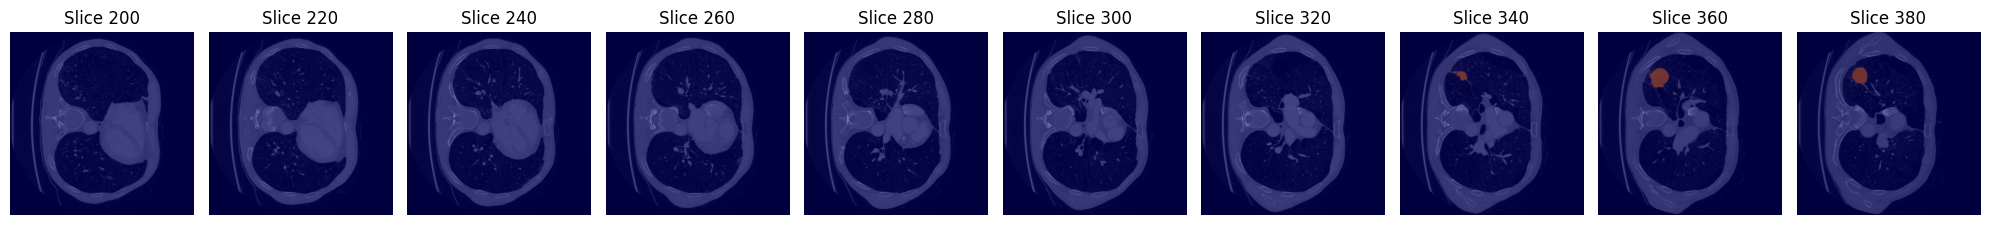

In [7]:
num_slices = 10
start_pos = 200
slice_interval = 20

image_data = data_check['image']
label_data = data_check['label']

fig, axes = plt.subplots(1, num_slices, figsize=(20, 6))

for i in range(num_slices):
    current_slide_index = start_pos + i * slice_interval

    # Ensure the slice index is within bounds
    if current_slide_index >= image_data.shape[2]:
        print(f"Warning: Slice index {current_slide_index} out of bounds. Adjust start_pos or slice_interval.")
        break

    ax = axes[i]
    ax.imshow(image_data[:, :, current_slide_index], cmap='gray')
    ax.imshow(label_data[:, :, current_slide_index], cmap='jet', alpha=0.5)
    ax.set_title(f'Slice {current_slide_index}')
    ax.axis('off') # Hide axes for clarity

plt.tight_layout()
plt.show()

### Exercițiul 2

Aplicați o serie de transformări pe imaginea și eticheta din obiectul data_check pentru a le pregăti pentru antrenarea unui model de segmentare. Transformările trebuie să includă:



1.   Redimensionarea imaginii și etichetei la dimensiunea 256x256.
2.   Rotirea imaginii și etichetei cu 45 de grade în sensul acelor de ceasornic (Hint: ```np.pi/4```).
3. Aplicarea unui flip vertical asupra imaginii și etichetei.

Pentru testare, folosiți ```slide = 360```.



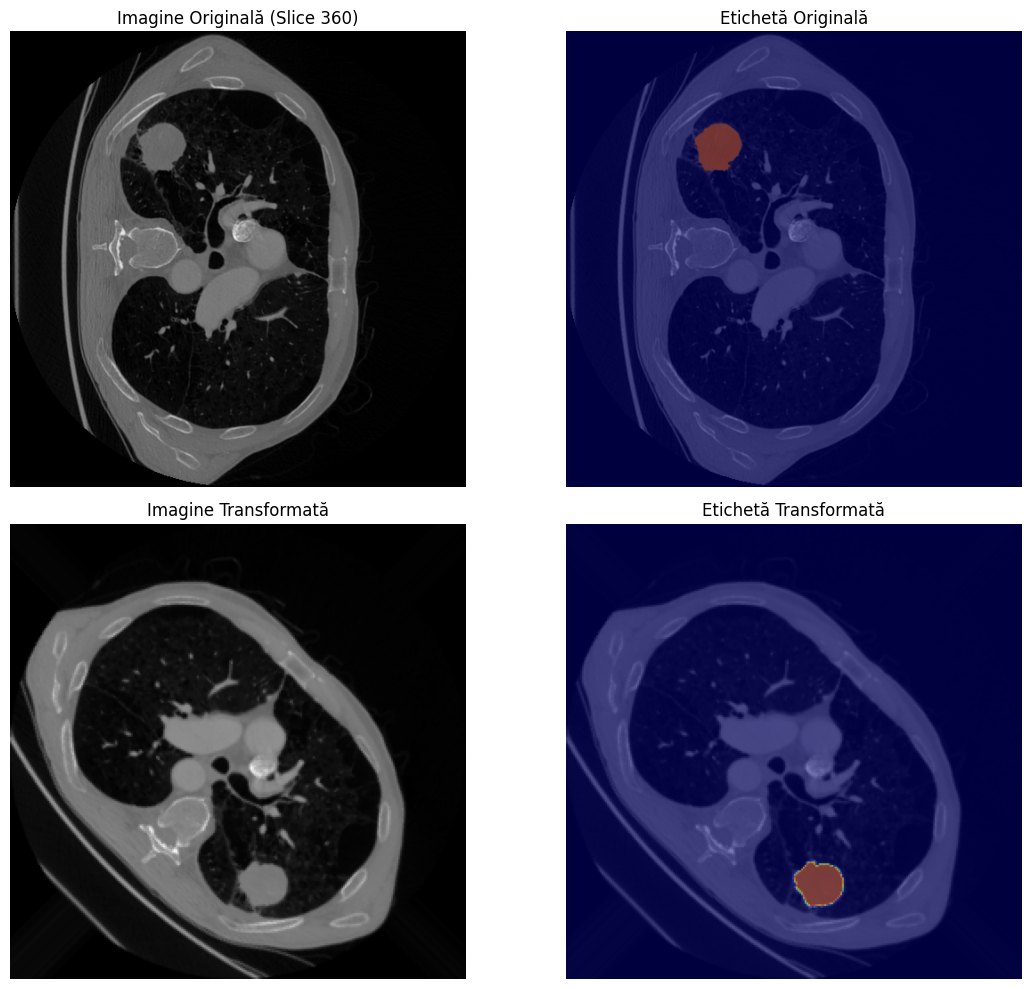

In [17]:
from monai.transforms import Resize, Rotate, Flip, Compose

transforms = Compose([
    # TODO: Definirea transformarilor
    Resize((256, 256)),
    Rotate(np.pi/4),
    Flip(spatial_axis=0)

])

slide = 360
image = data_check['image'][:, :, slide].unsqueeze(0)
label = data_check['label'][:, :, slide].unsqueeze(0)

# Aplicarea transformărilor
data_transformed = {
    "image": transforms(image), # TODO
    "label": transforms(label) # TODO
}

# TODO: plotarea imaginilor
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Imagine originală
axes[0, 0].imshow(image[0, :, :], cmap="gray")
axes[0, 0].set_title(f"Imagine Originală (Slice {slide})")
axes[0, 0].axis("off")

# Etichetă originală
axes[0, 1].imshow(image[0, :, :], cmap="gray")
axes[0, 1].imshow(label[0, :, :], cmap="jet", alpha=0.5)
axes[0, 1].set_title("Etichetă Originală")
axes[0, 1].axis("off")

# Imagine transformată
axes[1, 0].imshow(data_transformed["image"][0, :, :], cmap="gray")
axes[1, 0].set_title("Imagine Transformată")
axes[1, 0].axis("off")

# Etichetă transformată
axes[1, 1].imshow(data_transformed["image"][0, :, :], cmap="gray")
axes[1, 1].imshow(data_transformed["label"][0, :, :], cmap="jet", alpha=0.5)
axes[1, 1].set_title("Etichetă Transformată")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


### Exercițiul 3

Folosiți imaginea și eticheta pacientului (de exemplu, lung_014.nii.gz din setul de date Task06_Lung), și determinați câte slice-uri conțin țesut tumoral (adică, regiuni marcate în etichete cu valoarea 1).

Pentru acest pacient, avem deja datele stocate în ```data_check```.

In [18]:
label_data = data_check['label']
num_slices_with_tumor = 0

for i in range(label_data.shape[2]):
    slice_data = label_data[:, :, i]
    if (slice_data == 1).any():
        num_slices_with_tumor += 1

print(num_slices_with_tumor)

70


### Exercițiul 4

Folosiți imaginea și eticheta pacientului (de exemplu, lung_014.nii.gz din setul de date Task06_Lung), și determinați indicele slice-ului la care apare tumora cu aria maximă (adică, cea mai mare zonă marcată în etichete cu valoarea 1), precum și valoarea acestei arii.

In [20]:
label_data = data_check['label']

max_tumor_area = 0
slice_index_with_max_tumor = -1

# Iterate through each slice along the third dimension (depth)
for i in range(label_data.shape[2]):
    slice_data = label_data[:, :, i]
    # Calculate the tumor area in the current slice (sum of pixels with value 1)
    current_tumor_area = (slice_data == 1).sum().item() # .item() to get scalar from 0-dim tensor

    # Check if this slice has a larger tumor area than the current maximum
    if current_tumor_area > max_tumor_area:
        max_tumor_area = current_tumor_area
        slice_index_with_max_tumor = i

print(max_tumor_area, slice_index_with_max_tumor)

2303 364


## Load training set

In [21]:
# Set up transform
KEYS = ["image", "label"]
transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS,
             pixdim = (1., 1., 1.),
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS,
            (128, 128, 64),
            mode=('trilinear', 'nearest')),
    RandAffineD(keys = KEYS,
                spatial_size = (128, 128, 64),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

In [22]:
#edit transforms here
KEYS = ["image", "label"]

train_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityD(keys="image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    RandAffineD(
        keys=KEYS,
        spatial_size=(128, 128, 64),
        rotate_range=(0, 0, np.pi/12),
        scale_range=(0.1, 0.1, 0.1),
        mode=('bilinear', 'nearest'),
        prob=0.5
    ),
    RandFlipD(keys=KEYS, spatial_axis=0, prob=0.5),
    RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
    RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensorD(keys=KEYS),
])

In [23]:
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = False)
train_loader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 8)

# Check transformed data
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

# Trying to understand what the dimension 2 of the data is
print(training_image[0, :, 0, 0, 39])

Loading dataset: 100%|██████████| 51/51 [12:19<00:00, 14.50s/it]

Length of training set: 13


check data training image shape: torch.Size([4, 1, 128, 128, 64]) 
check data training label shape: torch.Size([4, 1, 128, 128, 64])
metatensor([0.])


## Load validation set

In [24]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

2025-11-12 09:06:01,964 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2025-11-12 09:06:01,965 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2025-11-12 09:06:01,967 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 12/12 [02:55<00:00, 14.60s/it]


In [25]:
# Check transformed data
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 12
check data image shape: torch.Size([1, 1, 128, 128, 64]) 
check data label shape: torch.Size([1, 1, 128, 128, 64])


# Model, Loss, Optimizer

In [35]:
device = torch.device("cuda:0")

UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (64, 128, 256, 512),
    strides = (2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
)

model = UNet(**UNet_metadata).to(device) # using UNet model

loss_function = DiceLoss(to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # using Adam optimizer
dice_metric = DiceMetric(include_background = False, reduction = "mean")

# Start training

In [36]:
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
metric_values = []
epoch_loss_values =[]
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

for epoch in range(max_epochs):
  print("-" * 12)
  print(f"Epoch {epoch + 1}/{max_epochs}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    # A common pytorch Deep Learning format to train model
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():.4f}")

  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
    # Turn model to "eval" mode
    model.eval()

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True
    with torch.no_grad():
      for val_data in val_loader:
        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (128, 128, 96)
        sw_batch_size = 1

        # Set AMP for MONAI validation
        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]

        # Compute metric for current iteration
        dice_metric(y_pred = val_output, y = val_label)

      # Aggregate the final mean dice result
      metric = dice_metric.aggregate().item()

      # Reset the status for the next epoch
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")

      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

------------
Epoch 1/10
1/12, train_loss: 0.6439
2/12, train_loss: 0.6238
3/12, train_loss: 0.6044
4/12, train_loss: 0.5884
5/12, train_loss: 0.5779
6/12, train_loss: 0.5681
7/12, train_loss: 0.5597
8/12, train_loss: 0.5523
9/12, train_loss: 0.5430
10/12, train_loss: 0.5391
11/12, train_loss: 0.5332
12/12, train_loss: 0.5277
13/12, train_loss: 0.5225
epoch 1 average loss: 0.5680
saved new best metric model!!!
current epoch: 1, current mean dice: 0.0003, best mean dice: 0.0003, at epoch: 1
------------
Epoch 2/10
1/12, train_loss: 0.5188
2/12, train_loss: 0.5160
3/12, train_loss: 0.5122
4/12, train_loss: 0.5109
5/12, train_loss: 0.5090
6/12, train_loss: 0.5073
7/12, train_loss: 0.5062
8/12, train_loss: 0.5052
9/12, train_loss: 0.5039
10/12, train_loss: 0.5039
11/12, train_loss: 0.5033
12/12, train_loss: 0.5028
13/12, train_loss: 0.5025
epoch 2 average loss: 0.5078
current epoch: 2, current mean dice: 0.0000, best mean dice: 0.0003, at epoch: 1
------------
Epoch 3/10
1/12, train_loss: 0

# Check model and Visualize

In [28]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0010 at epoch: 3


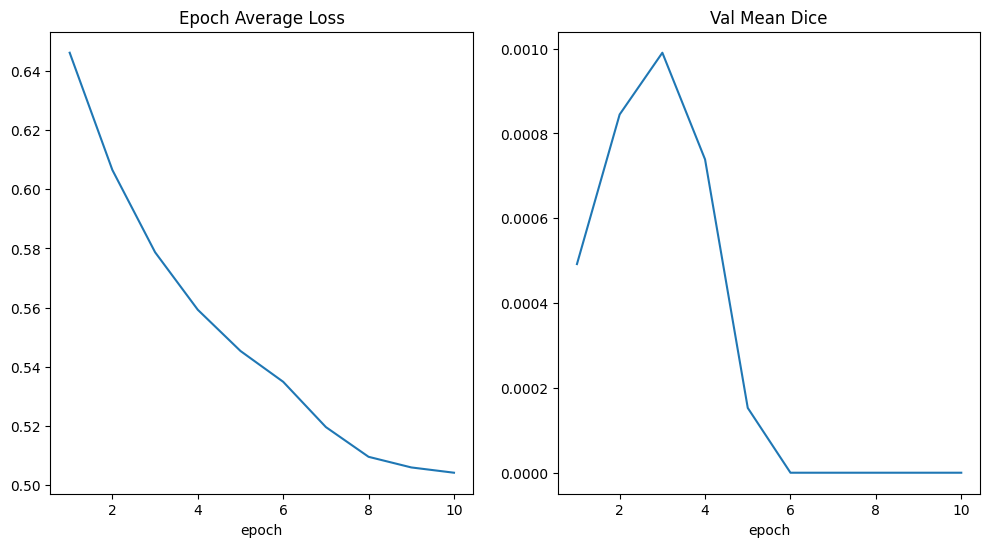

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('model_03_graph.png')
plt.show()
# plt.savefig(PATH_NAME+'model.png')

In [30]:
def predict(image, label, model):
    with torch.no_grad():
      output = model(image)
      output = torch.nn.Softmax()(output)
      output = torch.round(output)

      print(f"Output shape: {output.shape}")

      slide = 28
      plt.figure("Test Model", (12, 12))

      plt.subplot(1, 3, 1)
      plt.title("Input")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

      plt.subplot(1, 3, 2)
      plt.title("Label")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
      plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

      plt.subplot(1, 3, 3)
      plt.title("Output")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
      plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

      plt.show()

for i in range(50):
    checker = first(val_loader)
    image, label = checker['image'], checker['label']
    predict(image, label, model)

NotImplementedError: Could not run 'aten::slow_conv3d_forward' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::slow_conv3d_forward' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU_2.cpp:8588 [kernel]
Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMAIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_4.cpp:13560 [kernel]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastMTIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:466 [backend fallback]
AutocastMAIA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:504 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:542 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]
